In [1]:
import random
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw
import math
import pandas as pd
from tqdm import tqdm

%matplotlib inline

np.random.seed(42)
random.seed(42)

In [2]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move
    """
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1:
        return math.sqrt(2)
    else:
        raise ValueError("Trying to compute the cost of a non-supported move!")

In [3]:

class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node
    f : float | int
        f-value of the node
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return (self.i == other.i) and (self.j == other.j)

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

In [4]:

class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = {}  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_dublicates = 0  # Number of dublicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        if not self._open or len(self._open) == 0:
            return None
        best_node = heappop(self._open)
        while self.was_expanded(best_node):
            self._enc_open_dublicates += 1
            if not self._open or len(self._open) == 0:
                return None 
            best_node = heappop(self._open)
        return best_node

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

In [5]:

def make_path(goal: Node) -> Tuple[List[Node], Union[float, int]]:
    """
    Creates a path by tracing parent pointers from the goal node to the start node.
    It also returns the path's length.

    Parameters
    ----------
    goal : Node
        Pointer to the goal node in the search tree.

    Returns
    -------
    Tuple[List[Node], float]
        Path and its length.
    """
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [6]:

def octile_distance(i1: int, j1: int, i2: int, j2: int) -> int:
    """
    Computes the Octile distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    int
        Octile distance between the two cells.
    """
    return min(abs(i1 - i2), abs(j1 - j2)) * math.sqrt(2) + abs(abs(i1 - i2) - abs(j1 - j2))

In [7]:

class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 4-connected, allowing moves only in cardinal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbors.append((ni, nj))
        delta = ((1, 1), (1, -1), (-1, -1), (-1, 1))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj) and self.traversable(ni, j) and self.traversable(i, nj):
                neighbors.append((ni, nj))
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [8]:

def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    goal_node = Node(goal_i, goal_j)

    while not ast.open_is_empty():
        steps += 1
        best = ast.get_best_node_from_open()
        if not best:
            break
        if goal_node == best:
            return True, best, steps, len(ast), ast.opened, ast.expanded
        neighbours = task_map.get_neighbors(best.i, best.j)
        for neighbour in neighbours:
            cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j), parent=best)
            if not ast.was_expanded(cur_node):
                ast.add_to_open(cur_node)
        ast.add_to_closed(best)

    return False, None, steps, len(ast), None, ast.expanded

In [13]:

def wastar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
    w : float,
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=w * heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    goal_node = Node(goal_i, goal_j)

    while not ast.open_is_empty():
        steps += 1
        best = ast.get_best_node_from_open()
        if not best:
            break
        if goal_node == best:
            return True, best, steps, len(ast), ast.opened, ast.expanded
        neighbours = task_map.get_neighbors(best.i, best.j)
        for neighbour in neighbours:
            cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=w * heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j), parent=best)
            if not ast.was_expanded(cur_node):
                ast.add_to_open(cur_node)
        ast.add_to_closed(best)

    return False, None, steps, len(ast), None, ast.expanded

In [9]:

def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    """
    Converts a string representation of a grid map, with '@' for obstacles and '.' for free cells, into a binary matrix.

    Parameters
    ----------
    cell_str : str
        String containing grid map information ('@' for obstacles and '.' for free cells).

    Returns
    ----------
    cells : np.ndarray
        Binary matrix representing the grid map.
    """
    lines = cell_str.replace(" ", "").split("\n")

    cells = np.array(
        [[1 if char == "@" else 0 for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

In [10]:

def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )

def draw(
    grid_map: Map,
    start: Optional[Node] = None,
    goal: Optional[Node] = None,
    path: Optional[Iterable[Node]] = None,
    nodes_discovered: Optional[Iterable[Node]] = None,
    nodes_expanded: Optional[Iterable[Node]] = None,
    nodes_reexpanded: Optional[Iterable[Node]] = None,
):
    """
    Visualizes the environment, path, and expanded/not yet expanded/re-expanded nodes.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start, goal : Optional[Node], Optional[Node]
        Nodes for the start and goal positions of the agent.
    path : Optional[Iterable[Node]]
        Sequence of nodes representing the path between start and goal.
    nodes_discovered : Optional[Iterable[Node]]
        Nodes that were discovered during the search process.
    nodes_expanded : Optional[Iterable[Node]]
        Nodes that were expanded during the search process.
    nodes_reexpanded : Optional[Iterable[Node]]
        Nodes that were re-expanded during the search process.
    """
    scale = 5
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146)),
        (nodes_reexpanded, (255, 145, 146)),
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step in path:
            color = (52, 152, 219) if grid_map.traversable(step.i, step.j) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)

    if start is not None and grid_map.traversable(start.i, start.j):
        draw_rectangle(draw, start, scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.i, goal.j):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

In [11]:

def read_map_from_file(
    path: str,
) -> npt.NDArray:
    """
    Reads map.

    Parameters
    ----------
    path : str
        Path to a file with the pathfinding problem instance.

    Returns
    -------
    cells : npt.NDArray
        Matrix of grid map cells.
    """
    with open(path) as tasks_file:
        height = int(next(tasks_file))
        width = int(next(tasks_file))

        # Read the map section
        map_lines = [next(tasks_file) for _ in range(height)]
        map_str = "".join(map_lines)
        cells = convert_string_to_cells(map_str)

    return cells

In [12]:

def read_task_from_file(
    path: str,
):
    """
    Reads start/goal positions, and true value of path length between the given start and goal from a file.
    Choose randomly 100 tasks.

    Parameters
    ----------
    path : str
        Path to a file with the pathfinding problem instance.

    Returns
    -------
    tasks : np.array
        100 tasks
    """
    tasks = []
    with open(path) as tasks_file:
        for line in tasks_file:
            task = line.split()
            x_start = int(task[4])
            y_start = int(task[5])
            x_goal = int(task[6])
            y_goal = int(task[7])
            length = float(task[8])
            tasks.append([x_start, y_start, x_goal, y_goal, length])
    tasks = np.array(tasks)
    indices = np.random.choice(np.arange(len(tasks)), 100)
    tasks = tasks[indices]
    return tasks

In [24]:

def massive_test(data_path) -> pd.DataFrame:
    maps = ['AR0300SR.map', 'Berlin_2_512.map', 'maze512-32-9.map']
    df = pd.DataFrame({'map' : [], 'algorithm' : [], 'is_correct' : [], 'number_of_steps' : [], 'search_tree_size' : [], 'length_difference' : []})
    ws = [1.05, 1.1, 1.5, 2., 5.]
    progress_bar = tqdm(total=len(maps) * (1 + len(ws)) * 100)
    for field in maps:
        task_map = Map(read_map_from_file(Path(data_path) / field))
        tasks = read_task_from_file(Path(data_path) / f'{field}.scen')
        for task in tasks:
            try:
                (
                    found,
                    end_node,
                    number_of_steps,
                    search_tree_size,
                    *other_results,
                ) = astar(task_map, int(task[1]), int(task[0]), int(task[3]), int(task[2]), octile_distance, SearchTreePQD)
                #i = y, j = x
                new_row = {'map' : field, 'algorithm' : 'astar', 'is_correct' : False, 'number_of_steps' : 0, 'search_tree_size' : 0, 'length_difference' : 0.0}
                if found:
                    _, path_length = make_path(end_node)
                    correct = abs(path_length - task[4]) < 1e-6
                    new_row['is_correct'] = correct
    
                new_row["search_tree_size"] = search_tree_size
                new_row["number_of_steps"] = number_of_steps
                new_row['length_difference'] = path_length - task[4]
                df = df._append(new_row, ignore_index=True)
                progress_bar.update()
                
            except Exception as e:
                    print(f"Execution error: {e}")
                    traceback.print_exc()

            for w in ws:
                try:
                    (
                        found,
                        end_node,
                        number_of_steps,
                        search_tree_size,
                        *other_results,
                    ) = wastar(task_map, int(task[1]), int(task[0]), int(task[3]), int(task[2]), octile_distance, SearchTreePQD, w)
                    #i = y, j = x
                    new_row = {'map' : field, 'algorithm' : 'wastar' + '_' + str(w), 'is_correct' : False, 'number_of_steps' : 0, 'search_tree_size' : 0, 'length_difference' : 0.0}
                    if found:
                        _, path_length = make_path(end_node)
                        correct = abs(path_length - task[4]) < 1e-6
                        new_row['is_correct'] = correct
        
                    new_row["search_tree_size"] = search_tree_size
                    new_row["number_of_steps"] = number_of_steps
                    new_row['length_difference'] = path_length - task[4]
                    df = df._append(new_row, ignore_index=True)
                    progress_bar.update()
        
                except Exception as e:
                    print(f"Execution error: {e}")
                    traceback.print_exc()
    return df

# Используемые карты #

![AR0300SR](images/AR0300SR.png) 

![Berlin_2_512](images/Berlin_2_512.png) 

![maze512-32-9](images/maze512-32-9.png) 

In [25]:
df = massive_test('data')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [27:07<00:00,  1.11it/s]


In [26]:
display(df)

,map,algorithm,is_correct,number_of_steps,search_tree_size,length_difference
0,AR0300SR.map,astar,1.0,17096.0,19674.0,1.017527e-07
1,AR0300SR.map,wastar_1.05,True,15289.0,16716.0,1.017528e-07
2,AR0300SR.map,wastar_1.1,True,14195.0,15338.0,1.017528e-07
3,AR0300SR.map,wastar_1.5,True,4159.0,5958.0,1.017528e-07
4,AR0300SR.map,wastar_2.0,False,1950.0,3863.0,1.656854e+00
...,...,...,...,...,...,...
1795,maze512-32-9.map,wastar_1.05,True,60781.0,63989.0,6.105427e-08
1796,maze512-32-9.map,wastar_1.1,True,61037.0,64187.0,6.105427e-08
1797,maze512-32-9.map,wastar_1.5,True,67278.0,71282.0,6.105427e-08
1798,maze512-32-9.map,wastar_2.0,True,77895.0,81674.0,6.105427e-08


In [27]:
splited = df.groupby(['algorithm', 'map'])

In [28]:
splited_mean = splited.mean().reset_index()
splited_std = splited.std().reset_index()

In [29]:
display(splited_mean)
display(splited_std)

,algorithm,map,is_correct,number_of_steps,search_tree_size,length_difference
0,astar,AR0300SR.map,1.0,17742.20,21273.13,5.885167e-08
1,astar,Berlin_2_512.map,1.0,22711.52,30236.49,5.626535e-08
2,astar,maze512-32-9.map,1.0,147677.75,150946.08,1.493758e-07
3,wastar_1.05,AR0300SR.map,0.65,16061.00,17869.85,8.188940e-01
4,wastar_1.05,Berlin_2_512.map,0.48,17180.74,20767.48,1.318936e+00
5,wastar_1.05,maze512-32-9.map,0.21,146073.18,147918.41,1.971657e+00
6,wastar_1.1,AR0300SR.map,0.44,15334.52,16998.81,2.291413e+00
7,wastar_1.1,Berlin_2_512.map,0.35,14359.68,18076.44,3.092359e+00
8,wastar_1.1,maze512-32-9.map,0.19,145213.79,147058.95,5.616736e+00
9,wastar_1.5,AR0300SR.map,0.16,10481.90,12114.39,9.661000e+00


,algorithm,map,is_correct,number_of_steps,search_tree_size,length_difference
0,astar,AR0300SR.map,0.000000,14581.303584,15680.865738,3.895821e-08
1,astar,Berlin_2_512.map,0.000000,28040.398770,30036.928783,4.492460e-08
2,astar,maze512-32-9.map,0.000000,73691.920844,72085.154269,7.447803e-08
3,wastar_1.05,AR0300SR.map,0.479372,14103.471342,14459.996359,1.538821e+00
4,wastar_1.05,Berlin_2_512.map,0.502117,26303.454207,27334.526312,2.113568e+00
5,wastar_1.05,maze512-32-9.map,0.409360,74333.296187,74338.932844,1.845971e+00
6,wastar_1.1,AR0300SR.map,0.498888,13717.318441,14100.012937,3.532489e+00
7,wastar_1.1,Berlin_2_512.map,0.479372,24529.443487,25547.159046,4.302739e+00
8,wastar_1.1,maze512-32-9.map,0.394277,74194.120326,74218.648068,4.544474e+00
9,wastar_1.5,AR0300SR.map,0.368453,11033.766378,11367.826659,1.151156e+01


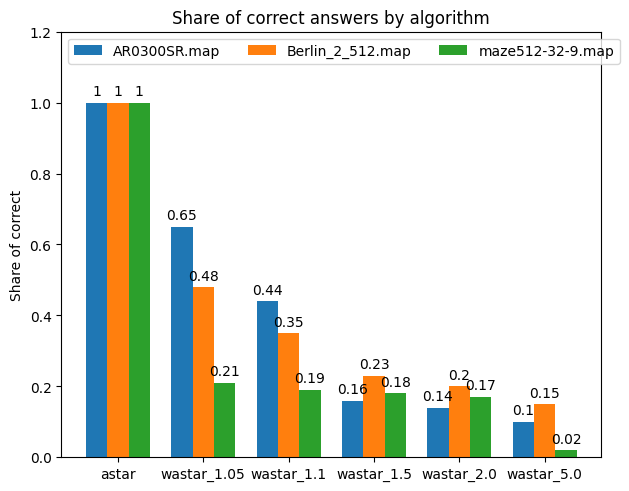

In [31]:
algorithms = ('astar', 'wastar_1.05', 'wastar_1.1', 'wastar_1.5', 'wastar_2.0', 'wastar_5.0')
maps = ('AR0300SR.map', 'Berlin_2_512.map', 'maze512-32-9.map')
is_correct_prob = {field : splited_mean[splited_mean['map'] == field]['is_correct'] for field in maps}
x = np.arange(len(algorithms))
fig, ax = plt.subplots(layout='constrained')
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in is_correct_prob.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Share of correct answers by algorithm')
ax.set_ylabel('Share of correct')
ax.set_xticks(x + width, algorithms)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)
plt.show()

## Описание графика ##
Каждый столбец показывает accuracy каждого алгоритма на конкретной карте.
## Выводы ##
По результатам эксперимента на графике видно, что accuracy падает с ростом параметра w.

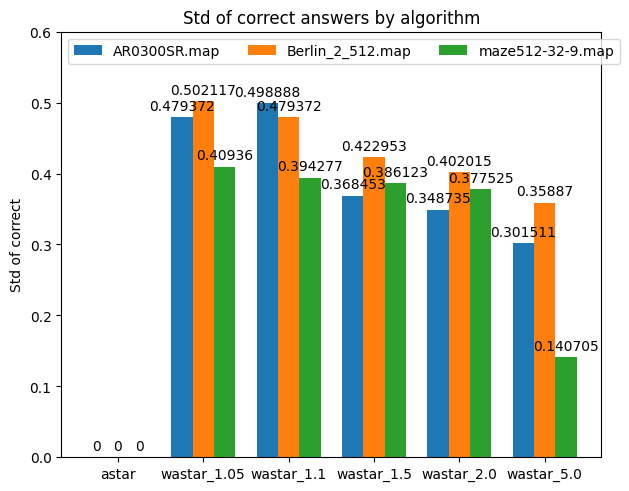

In [34]:
algorithms = ('astar', 'wastar_1.05', 'wastar_1.1', 'wastar_1.5', 'wastar_2.0', 'wastar_5.0')
maps = ('AR0300SR.map', 'Berlin_2_512.map', 'maze512-32-9.map')
is_correct_std = {field : splited_std[splited_std['map'] == field]['is_correct'] for field in maps}
x = np.arange(len(algorithms))
fig, ax = plt.subplots(layout='constrained')
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in is_correct_std.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Std of correct answers by algorithm')
ax.set_ylabel('Std of correct')
ax.set_xticks(x + width, algorithms)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.6)
plt.show()

## Описание графика ## 
Каждый столбец показывает std корректности каждого алгоритма на конкретной карте.
## Выводы ##
По результатам эксперимента на графике видно, что у wastar std корректности падает с ростом параметра w (кроме карты игры в случае w: 1.05 -> 1.1).

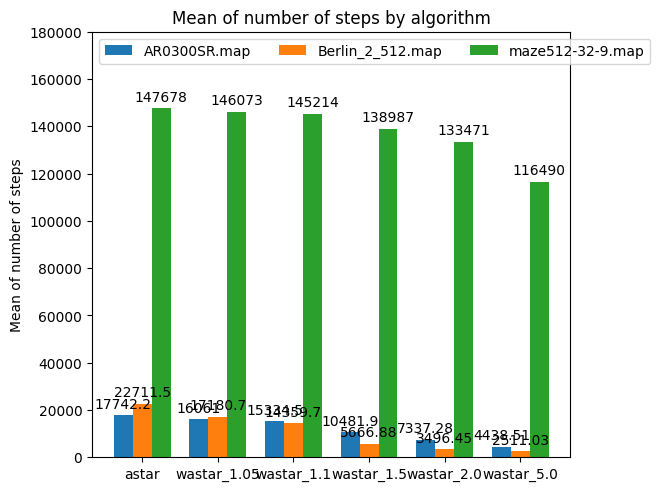

In [35]:
algorithms = ('astar', 'wastar_1.05', 'wastar_1.1', 'wastar_1.5', 'wastar_2.0', 'wastar_5.0')
maps = ('AR0300SR.map', 'Berlin_2_512.map', 'maze512-32-9.map')
steps_mean = {field : splited_mean[splited_mean['map'] == field]['number_of_steps'] for field in maps}
x = np.arange(len(algorithms))
fig, ax = plt.subplots(layout='constrained')
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in steps_mean.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Mean of number of steps by algorithm')
ax.set_ylabel('Mean of number of steps')
ax.set_xticks(x + width, algorithms)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 180000)
plt.show()

## Описание графика ## 
Каждый столбец показывает среднее значение количества шагов каждого алгоритма на конкретной карте.
## Выводы ##
По результатам эксперимента на графике видно, что среднее количество шагов падает с ростом параметра w.

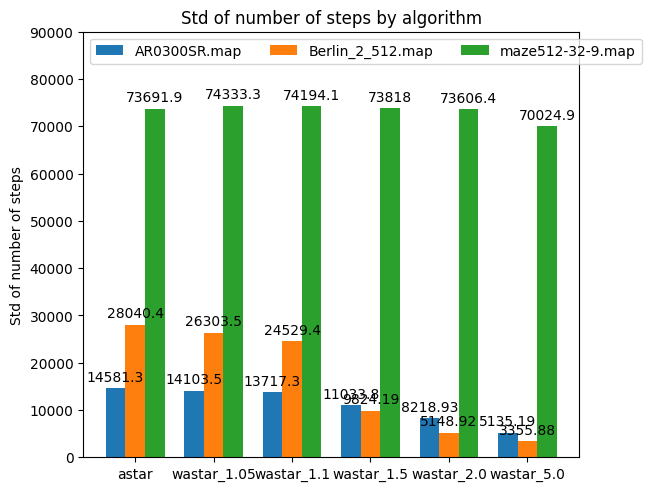

In [36]:
algorithms = ('astar', 'wastar_1.05', 'wastar_1.1', 'wastar_1.5', 'wastar_2.0', 'wastar_5.0')
maps = ('AR0300SR.map', 'Berlin_2_512.map', 'maze512-32-9.map')
steps_std = {field : splited_std[splited_std['map'] == field]['number_of_steps'] for field in maps}
x = np.arange(len(algorithms))
fig, ax = plt.subplots(layout='constrained')
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in steps_std.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Std of number of steps by algorithm')
ax.set_ylabel('Std of number of steps')
ax.set_xticks(x + width, algorithms)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 90000)
plt.show()

## Описание графика ## 
Каждый столбец показывает std значения количества шагов каждого алгоритма на конкретной карте.
## Выводы ##
По результатам эксперимента на графике видно, что std количества шагов падает с ростом параметра w (кроме карты лабиринта, у которой при w = 1 данное значение больше, чем у 1 < w < 2).

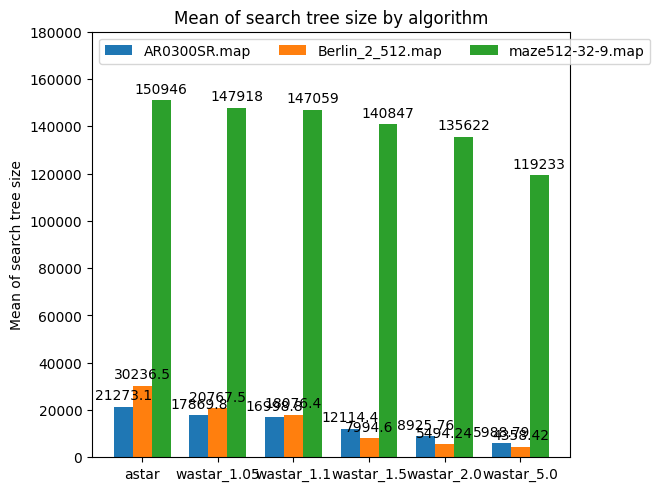

In [37]:
algorithms = ('astar', 'wastar_1.05', 'wastar_1.1', 'wastar_1.5', 'wastar_2.0', 'wastar_5.0')
maps = ('AR0300SR.map', 'Berlin_2_512.map', 'maze512-32-9.map')
tree_mean = {field : splited_mean[splited_mean['map'] == field]['search_tree_size'] for field in maps}
x = np.arange(len(algorithms))
fig, ax = plt.subplots(layout='constrained')
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in tree_mean.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Mean of search tree size by algorithm')
ax.set_ylabel('Mean of search tree size')
ax.set_xticks(x + width, algorithms)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 180000)
plt.show()

## Описание графика ## 
Каждый столбец показывает среднее значение размера дерева каждого алгоритма на конкретной карте.
## Выводы ##
По результатам эксперимента на графике видно, что среднее значение размера дерева падает с ростом параметра w.

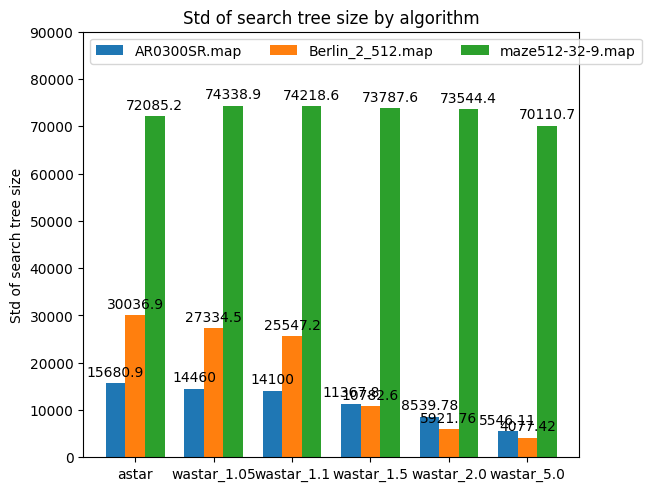

In [38]:
algorithms = ('astar', 'wastar_1.05', 'wastar_1.1', 'wastar_1.5', 'wastar_2.0', 'wastar_5.0')
maps = ('AR0300SR.map', 'Berlin_2_512.map', 'maze512-32-9.map')
tree_std = {field : splited_std[splited_std['map'] == field]['search_tree_size'] for field in maps}
x = np.arange(len(algorithms))
fig, ax = plt.subplots(layout='constrained')
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in tree_std.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Std of search tree size by algorithm')
ax.set_ylabel('Std of search tree size')
ax.set_xticks(x + width, algorithms)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 90000)
plt.show()

## Описание графика ## 
Каждый столбец показывает std значения размера дерева каждого алгоритма на конкретной карте.
## Выводы ##
По результатам эксперимента на графике видно, что std значения размера дерева падает с ростом параметра w (кроме карты лабиринта, у которой при w = 1 данное значение больше, чем у 1 < w < 5).

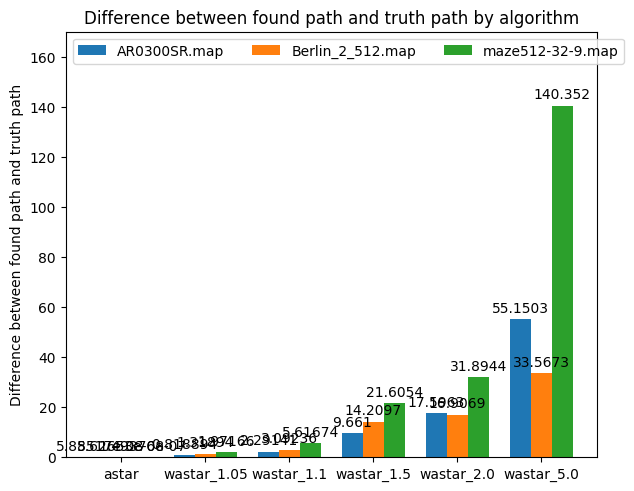

In [44]:
algorithms = ('astar', 'wastar_1.05', 'wastar_1.1', 'wastar_1.5', 'wastar_2.0', 'wastar_5.0')
maps = ('AR0300SR.map', 'Berlin_2_512.map', 'maze512-32-9.map')
length_diff = {field : splited_mean[splited_mean['map'] == field]['length_difference'] for field in maps}
x = np.arange(len(algorithms))
fig, ax = plt.subplots(layout='constrained')
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in length_diff.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Difference between found path and truth path by algorithm')
ax.set_ylabel('Difference between found path and truth path')
ax.set_xticks(x + width, algorithms)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 170)
plt.show()

## Описание графика ## 
Каждый столбец показывает среднее значение разности между длиной найденного и длиной истинного пути каждого алгоритма на конкретной карте.
## Выводы ##
По результатам эксперимента на графике видно, что среднее значение разности между длиной найденного и длиной истинного пути растёт с ростом параметра w.

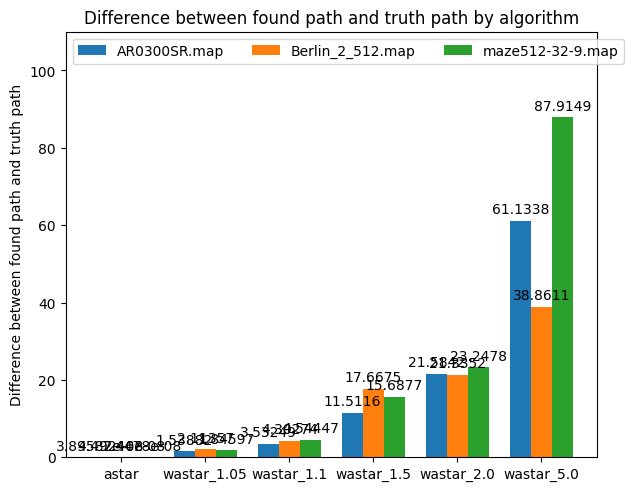

In [47]:
algorithms = ('astar', 'wastar_1.05', 'wastar_1.1', 'wastar_1.5', 'wastar_2.0', 'wastar_5.0')
maps = ('AR0300SR.map', 'Berlin_2_512.map', 'maze512-32-9.map')
length_diff = {field : splited_std[splited_std['map'] == field]['length_difference'] for field in maps}
x = np.arange(len(algorithms))
fig, ax = plt.subplots(layout='constrained')
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in length_diff.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Difference between found path and truth path by algorithm')
ax.set_ylabel('Difference between found path and truth path')
ax.set_xticks(x + width, algorithms)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 110)
plt.show()

## Описание графика ## 
Каждый столбец показывает std значения разности между длиной найденного и длиной истинного пути каждого алгоритма на конкретной карте.
## Выводы ##
По результатам эксперимента на графике видно, что std значения разности между длиной найденного и длиной истинного пути растёт с ростом параметра w.

# Выводы #
## Experimental setup ##
### Карты ###
Были взяты следующие карты (изображения всех карт можно посмотреть выше в формате png): карта из игры Baldur's gate 2, представляющая из себя некоторое подобие пещеры, карта берлина и карта лабиринта. Выбраны они были по следующим причинам: карта из игры представляет из себя более или менее естественную локациию, карта берлина — открытую местность с некоторым количееством препятствий, карта лабиринта — максимально искуственную локацию с прямоугольными проходами. Все карты имеют размер 512 на 512 пикселей.
### Задания ###
Задания выбираются случайно, в количестве 100 штук, так как там заданий одного уровня сложности мало, они расположены в одном промежутке и всего уровней сложности больше 100, можно утверждать, что в выборку попало достаточно много разных уровней сложности и мало заданий, принадлежащих какой-либо одной группе.
### Метрики ###
Отслеживались следующие метрики: правильно ли алгоритм нашёл оптимальный путь, сколько шагов сделал во время поиска, какой размер у дерева поиска получился и разность между длиной найденного и оптимального пути.
### Анализ трендов ###
По средним значениям всё как и ожидалось: увеличение параметра w в среднем ухудшает точность алгоритма и длину между найденным и оптимальным путём, но за то уменьшает размер дерева поиска и количество выполненных шагов.
Что касается std: оно падает у всех метрик кроме разности длины при w > 1 с увеличением w, предположу, что это связано с тем, что алгоритму требуется меньшее количество шагов, и пооэтому ему остаётся меньше времени на создание некоторого разброса. А у разности длины std возрастает, так как алгоритм начинает всё сильнее отдаляться от оптимального результата и там наоборот появляется пространство для разброса.

#  Для наглядности покажу построение путей всеми алгоритмами на всех картах на случайных, достаточно длинных заданиях #

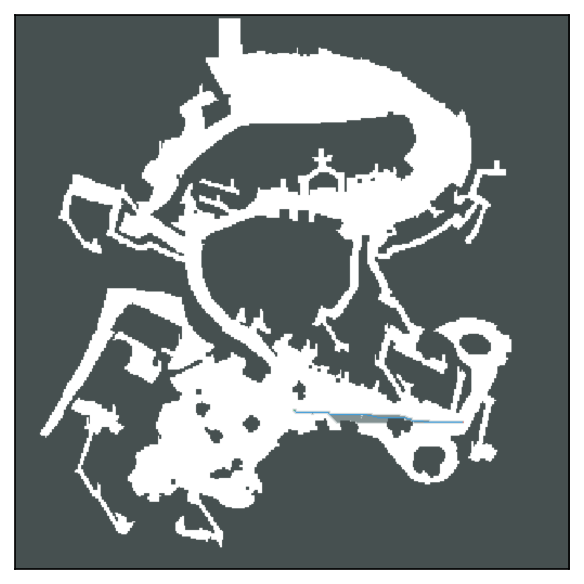

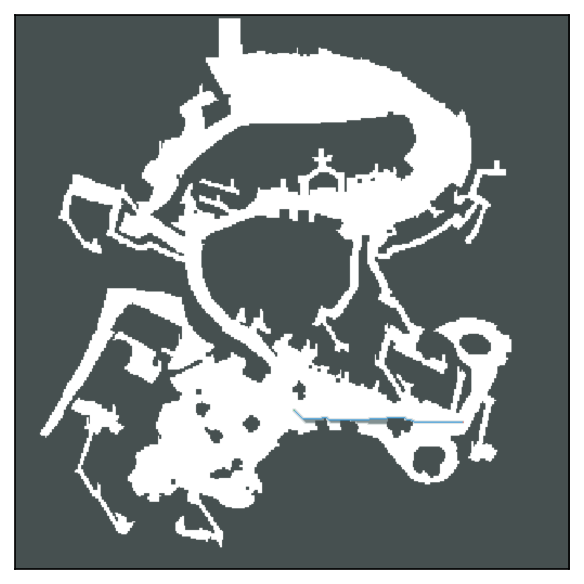

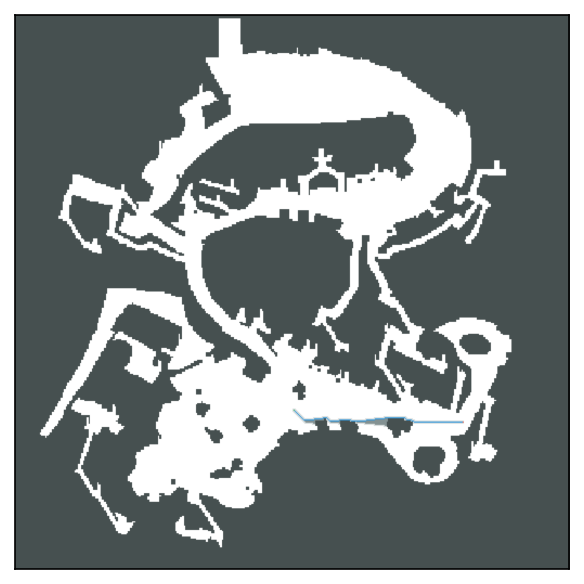

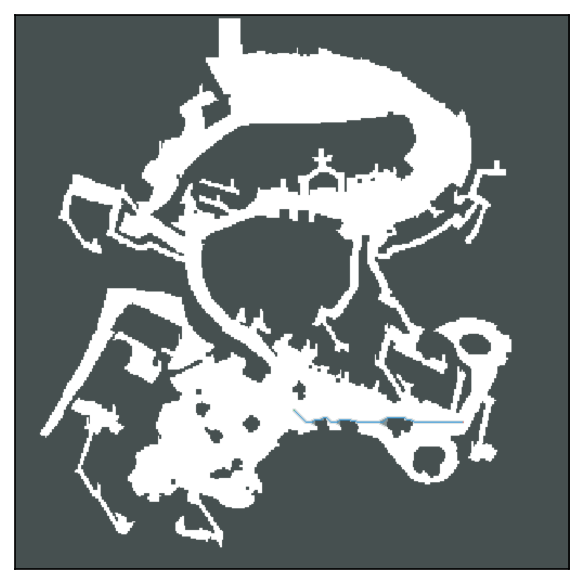

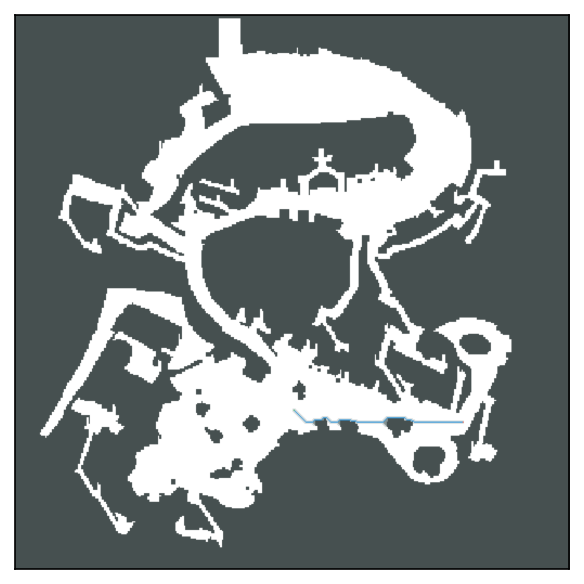

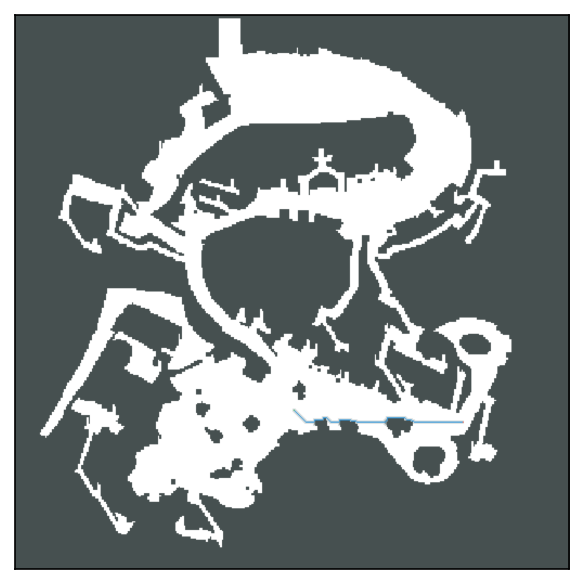

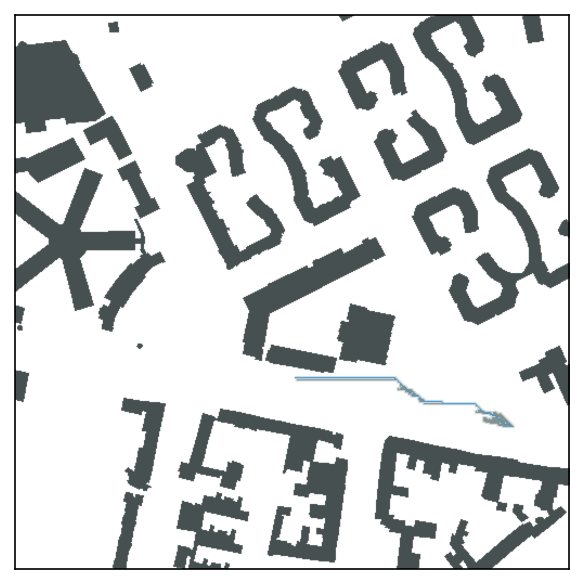

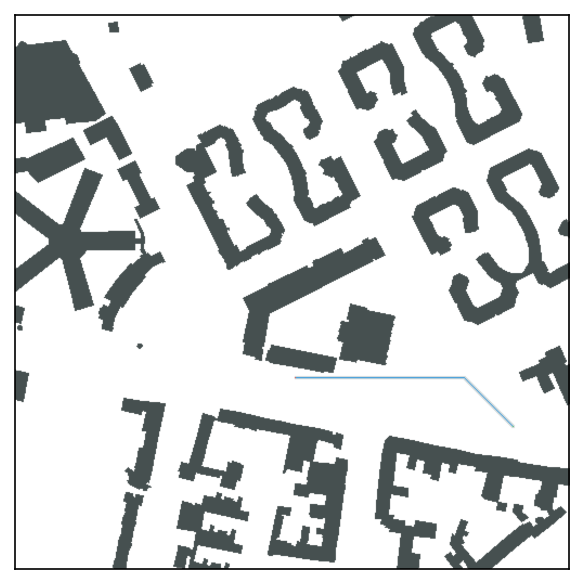

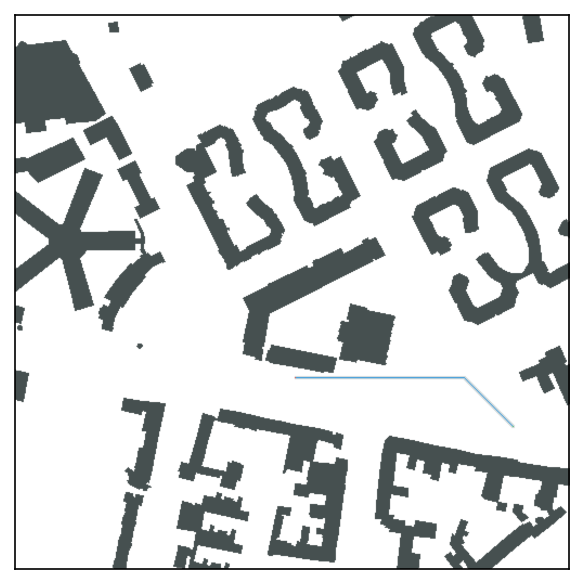

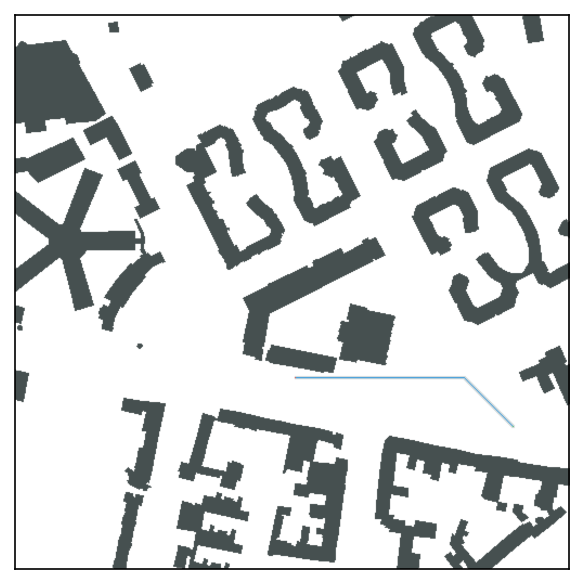

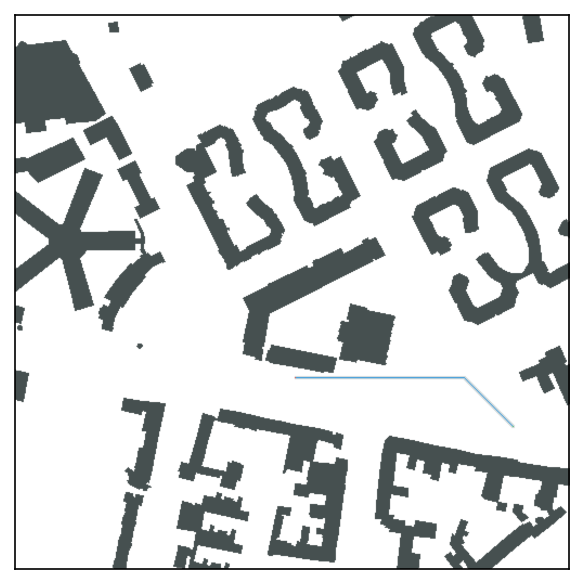

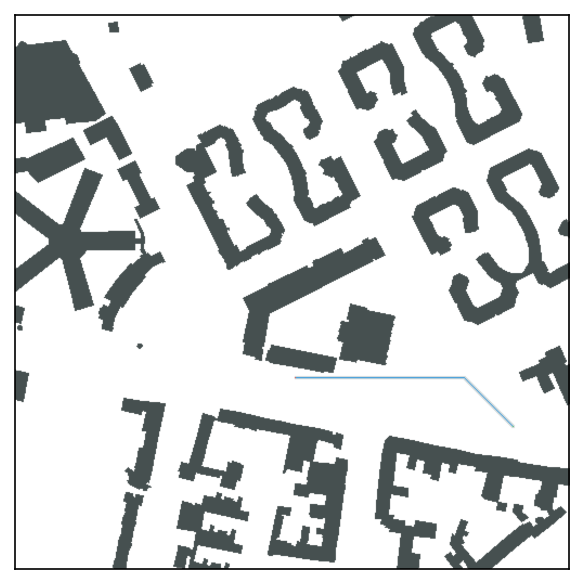

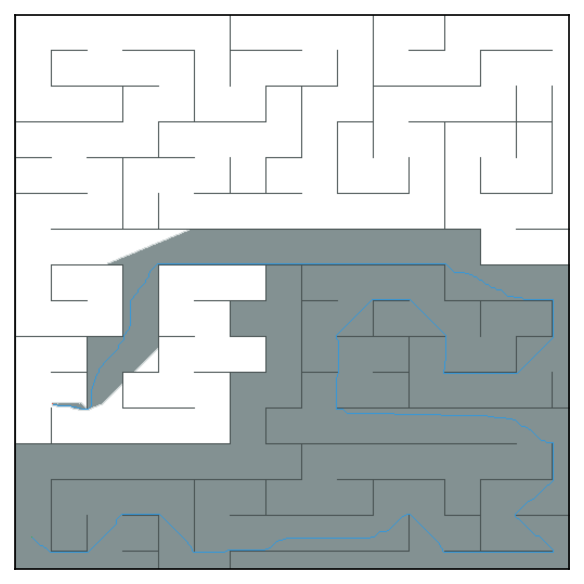

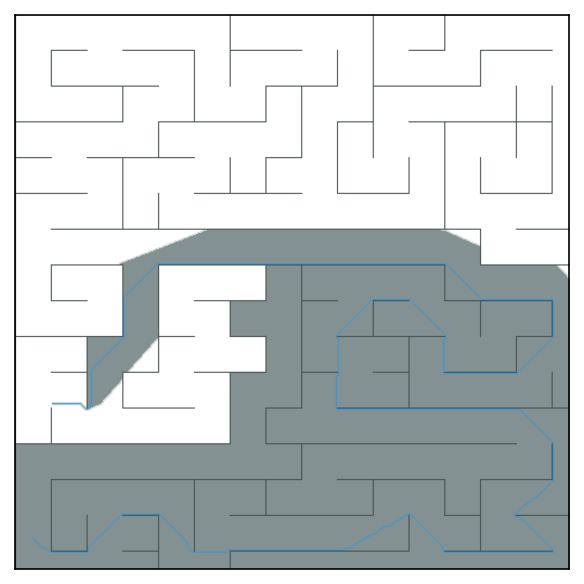

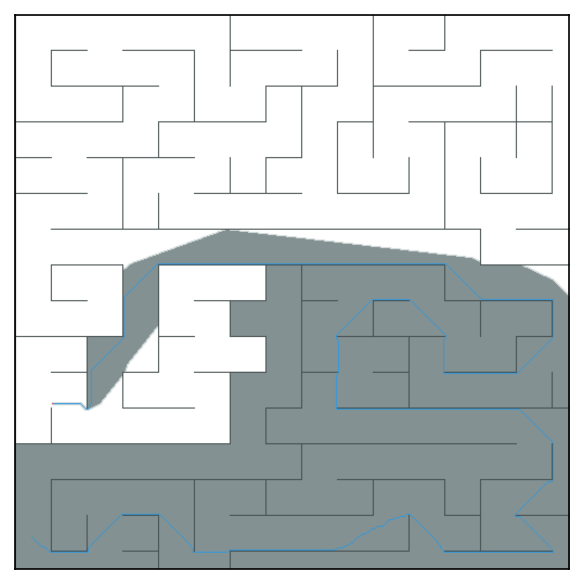

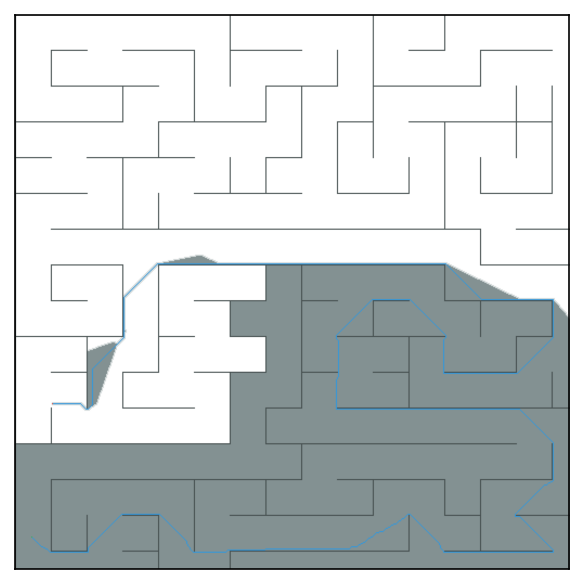

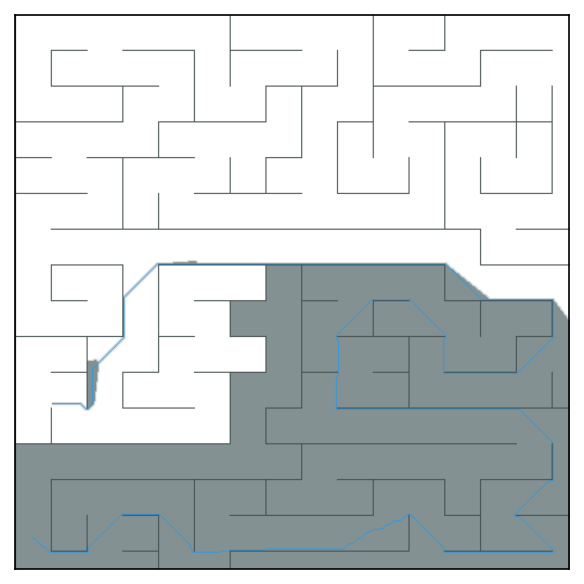

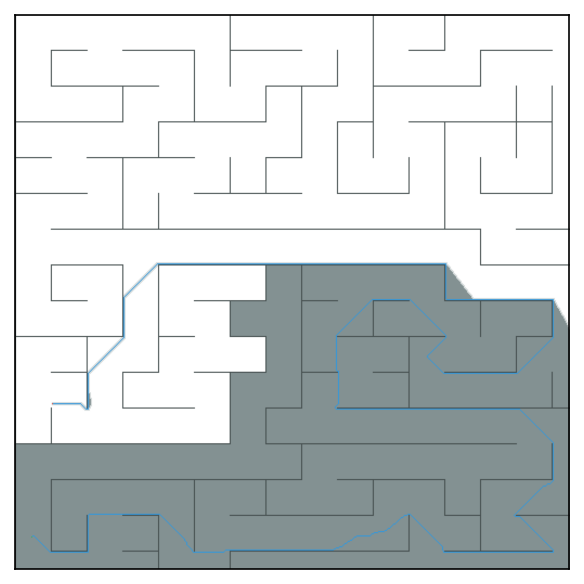

In [53]:
np.random.seed(1488)
for field in maps:
    task_map = Map(read_map_from_file(Path('data') / field))
    task = read_task_from_file(Path('data') / f'{field}.scen')[-1]
    (
        found,
        end_node,
        number_of_steps,
        search_tree_size,
        *other_results,
    ) = astar(task_map, int(task[1]), int(task[0]), int(task[3]), int(task[2]), octile_distance, SearchTreePQD)
    path, path_length = make_path(end_node)
    draw(task_map, Node(int(task[1]), int(task[0])), Node(int(task[3]), int(task[2])), path, *other_results)
    ws = [1.05, 1.1, 1.5, 2., 5.]
    for w in ws:
        (
            found,
            end_node,
            number_of_steps,
            search_tree_size,
            *other_results,
        ) = wastar(task_map, int(task[1]), int(task[0]), int(task[3]), int(task[2]), octile_distance, SearchTreePQD, w)
        path, path_length = make_path(end_node)
        draw(task_map, Node(int(task[1]), int(task[0])), Node(int(task[3]), int(task[2])), path, *other_results)